# 支持向量机
### 优点：
1. 适用于变量较多的数据，这是因为当p很大时，数据较为离散，使得超平面较容易将特征空间中的样本点分离。
2. 在数据存储方面更有效率，这是因为在预测时，SVM仅使用支持向量。
3. 可使用核技巧，使得SVM适用于非线性决策边界。

### 缺点：
1. 对于核函数中的参数比较敏感。
2. 对于真正的高维数据，SVM的效果可能不尽如人意，这是因为只有较少的支持向量来决定更高纬度的分离超平面，使得泛化能力较差。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
from sklearn.svm import SVC,SVR,LinearSVC
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston,load_digits,make_blobs

## 一、线性决策边界的支持向量分类器
1. 最大间隔分类器，又称硬分类器，最优化问题为：
   $$\underset{\beta,\beta_0}{min}\quad \frac{1}{2}\beta^{'}\beta$$
   $$s.t.\quad y_i(\beta_0+\beta^{'}x_i)\geq1$$
   解得：$$\hat\beta=\sum_{i=1}^{n}\alpha_iy_ix_i$$
2. 软间隔分类器，又称支持向量分类器，放松对约束条件的要求，只要求分离平面将大多数观测值正确分类即可，故引入松弛变量$\xi_i\geq0$，将最小化问题改写为：
   $$\underset{\beta,\beta_0,\xi_i}{min}\quad \frac{1}{2}\beta^{'}\beta+C\sum_{i=1}^n\xi_i$$
   $$s.t.\quad y_i(\beta_0+\beta^{'}x_i)\geq 1-\xi_i$$
   其优化算法为，惩罚错误分类的观测值个数，使用合页损失函数作为损失函数，若正确分类（$z_i\geq1$），则损失函数等于0：
   $$\zeta_{hinge}(z_i)=max(0,1-z_i),\quad\quad z_i=y_i(\beta_0+\beta x_i)$$
3. 若惩罚参数C无穷大（正则化程度较低），则软间隔分类器即为最大间隔分类器，其易受到极端值的影响，不稳健，可能导致过拟合。

In [2]:
X,y=make_blobs(n_samples=40,centers=2,n_features=2,random_state=6)
y=2*y-1#数据变换
data=pd.DataFrame(X,columns=['X1','X2'])

<AxesSubplot:xlabel='X1', ylabel='X2'>

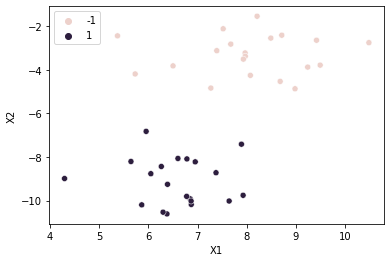

In [3]:
sns.scatterplot(x='X1',y='X2',data=data,hue=y)

### 1、使用LinearSVC处理线性分类问题

In [4]:
model=LinearSVC(C=1000,loss='hinge',random_state=123)
model.fit(X,y)

LinearSVC(C=1000, loss='hinge', random_state=123)

In [5]:
dist=model.decision_function(X)#观测值到分离超平面的距离，即f(x)
index=np.where(y*dist<=(1+1e-10))#防止计算偏差

In [6]:
np.array(X)[index]#支持向量

array([[ 5.73005848, -4.19481136],
       [ 7.89359985, -7.41655113]])

In [7]:
def support_vector(model,X,y):#model表示已拟合过的模型
    dist=model.decision_function(X)
    index=np.where(y*dist<=(1+1e-10))
    return np.array(X)[index]

def plot_svm(model,X,y):
    data=pd.DataFrame(X,columns=['x1','x2'])
    data['y']=y
    sns.scatterplot(x='x1',y='x2',data=data,hue=y,s=30)
    sv=support_vector(model,X,y)
    plt.scatter(sv[:,0],sv[:,1],facecolors='none',s=100,edgecolors='k')
    ax=plt.gca()
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    xx,yy=np.meshgrid(np.linspace(xlim[0],xlim[1],50),np.linspace(ylim[0],ylim[1],50))
    z=model.decision_function(np.c_[xx.ravel(),yy.ravel()])
    z=z.reshape(xx.shape)
    plt.contour(xx,yy,z,colors='k',levels=[-1,0,1],alpha=0.5,linestyles=['--','-','--'])
    C=model.get_params()['C']
    plt.title(f'SVM(C={C})')

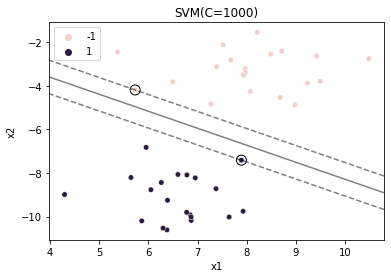

In [8]:
plot_svm(model,X,y)

/Users/singal/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


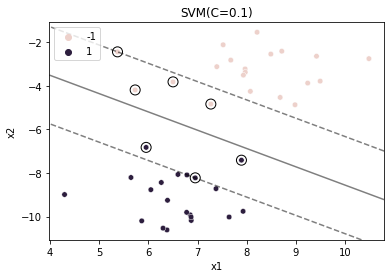

In [9]:
model=LinearSVC(C=0.1,loss='hinge',random_state=123).fit(X,y)
plot_svm(model,X,y)

In [10]:
param_grid={'C':[0.001,0.01,0.1,1,10,100]}
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
model=GridSearchCV(LinearSVC(loss='hinge',random_state=123,max_iter=1e4),param_grid=param_grid,cv=kfold)
model.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=LinearSVC(loss='hinge', max_iter=10000.0,
                                 random_state=123),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [11]:
model.best_params_

{'C': 0.01}

In [12]:
model=model.best_estimator_
model.coef_,model.intercept_

(array([[-0.23166329, -0.28402527]]), array([-0.02442051]))

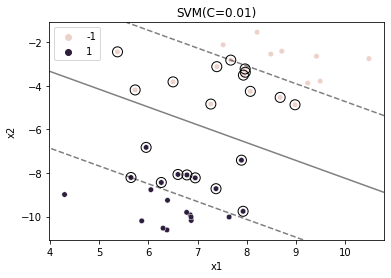

In [13]:
plot_svm(model,X,y)

### 2、使用SVC处理线性分类问题

In [14]:
model=SVC(kernel='linear',C=0.01,random_state=123)
model.fit(X,y)

SVC(C=0.01, kernel='linear', random_state=123)

两类数据各有9个支持向量，总共18个支持向量。

In [15]:
model.n_support_

array([9, 9], dtype=int32)

In [16]:
model.support_#支持向量的位置

array([ 1,  5,  7,  8, 16, 19, 24, 28, 38, 10, 11, 14, 20, 21, 23, 29, 30,
       31], dtype=int32)

In [17]:
model.support_vectors_[:5,:],X[model.support_][:5,:]#二者结果一致

(array([[ 6.50072722, -3.82403586],
        [ 8.68185687, -4.53683537],
        [ 9.24223825, -3.88003098],
        [ 5.73005848, -4.19481136],
        [ 7.27059007, -4.84225716]]),
 array([[ 6.50072722, -3.82403586],
        [ 8.68185687, -4.53683537],
        [ 9.24223825, -3.88003098],
        [ 5.73005848, -4.19481136],
        [ 7.27059007, -4.84225716]]))

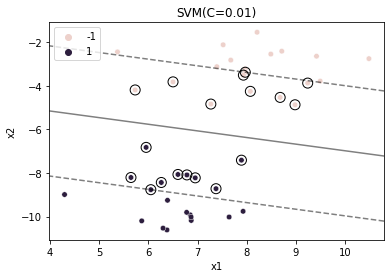

In [18]:
plot_svm(model,X,y)

### 3、结论
SVC和LinearSVC类的结果不相同，这是因为SVC类使用libsvm算法，LinearSVC使用liblinear算法。若数据较大，应使用LinearSVC，因为其已对线性问题作出了相应优化。
## 二、非线性决策边界的SVM
关键词：特征变换、核技巧

In [19]:
np.random.seed(1)
X=np.random.randn(200,2)
y=np.logical_xor(X[:,0]>0,X[:,1]>0)#异或函数
y=np.where(y,1,-1)#x1与x2一正一负则y=1

<AxesSubplot:xlabel='x1', ylabel='x2'>

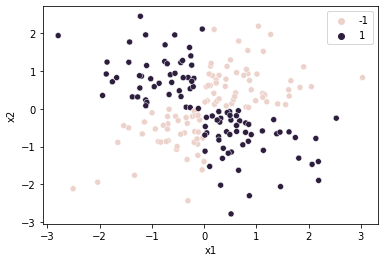

In [20]:
data=pd.DataFrame(X,columns=['x1','x2'])
data['y']=y
sns.scatterplot(x='x1',y='x2',data=data,hue=y)

决策边界为非线性，无法使用超平面分离，需对特征向量进行特征变换。

In [21]:
def results(model):

    num=model.n_support_
    print(f'每个类别下支持向量个数依次为{num[0]}，{num[1]}')
  
    score=model.score(X,y)
    print(f'样本内预测准确率为：{score}')

    plot_decision_regions(X,y,model,hide_spines=False)
    C=model.get_params()['C']
    gamma=model.get_params()['gamma']
    plt.title(f'SVM(C={C},gamma={gamma})')

每个类别下支持向量个数依次为46，47
样本内预测准确率为：0.93


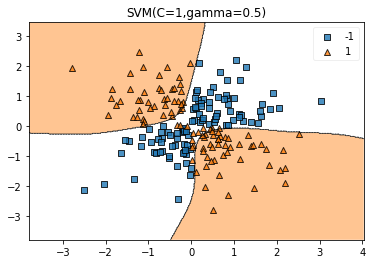

In [22]:
model=SVC(kernel='rbf',C=1,gamma=0.5,random_state=123)
model.fit(X,y)
results(model)

预测效果良好。

每个类别下支持向量个数依次为3，10
样本内预测准确率为：1.0


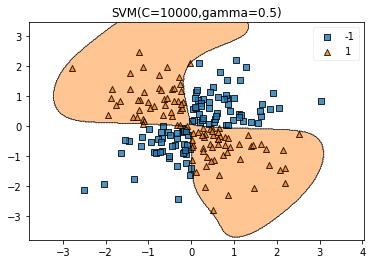

In [23]:
model=SVC(kernel='rbf',C=10000,gamma=0.5,random_state=123)
model.fit(X,y)
results(model)

惩罚参数过大，导致决策边界较为扭曲，这是过拟合的一种表现。

每个类别下支持向量个数依次为100，100
样本内预测准确率为：0.875


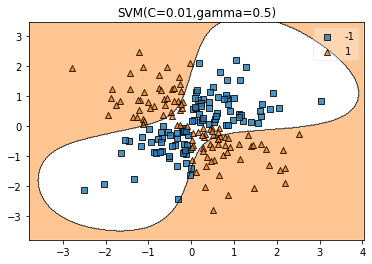

In [24]:
model=SVC(kernel='rbf',C=0.01,gamma=0.5,random_state=123)
model.fit(X,y)
results(model)

惩罚参数过小，导致决策边界过分光滑，未能很好地区分两类数据，导致欠拟合。

每个类别下支持向量个数依次为88，95
样本内预测准确率为：1.0


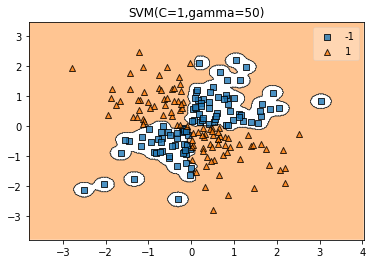

In [25]:
model=SVC(kernel='rbf',C=1,gamma=50,random_state=123)
model.fit(X,y)
results(model)

每个观测值的影响范围变小，出现了较为严重的过拟合。

每个类别下支持向量个数依次为90，89
样本内预测准确率为：0.715


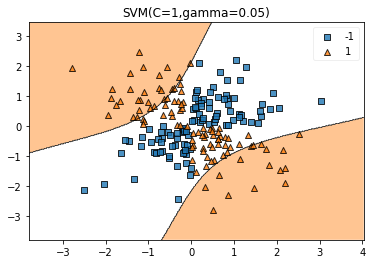

In [26]:
model=SVC(kernel='rbf',C=1,gamma=0.05,random_state=123)
model.fit(X,y)
results(model)

每个观测值的影响范围很大，导致决策边界过于光滑，欠拟合。

In [27]:
param_grid={'C':[0.001,0.01,0.1,1,10,100]}
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
model=GridSearchCV(SVC(kernel='rbf',random_state=123),param_grid=param_grid,cv=kfold)
model.fit(X,y)
print('最佳超参数为：',model.best_params_)
model=model.best_estimator_

最佳超参数为： {'C': 100}


每个类别下支持向量个数依次为13，15
样本内预测准确率为：0.98


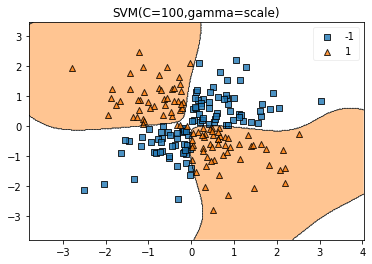

In [28]:
results(model)

最优模型的拟合效果较好，既无欠拟合也无过拟合。前两大部分为模拟训练，仅为演示代码需要，故未设置测试集。
## 三、支持向量机的二分类问题
关键词：特征变换、核技巧

In [29]:
data=pd.read_csv('/Users/singal/Desktop/Data/MLPython_Data/spam.csv')
data.shape

(4601, 58)

In [30]:
data.head()

,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,...,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


In [31]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=1000,stratify=y,random_state=0)

In [32]:
X.describe()

,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,...,A.48,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


从数据矩阵的描述性统计分析可以看出，某些特征变量的均值和标准差有较大差异，故先将特征变量标准化后，再进行SVM估计。  
注意，不能使用测试集的均值和标准差来标准化测试集数据。

In [33]:
scaler=StandardScaler().fit(xtrain)
xtrain=scaler.transform(xtrain)
xtest=scaler.transform(xtest)

In [34]:
def matrix_metrics(model):#此函数仅适用于二分类问题

    pred=model.predict(xtest)
    matrix=confusion_matrix(ytest,pred)

    accuracy=(matrix[0,0]+matrix[1,1])/matrix.sum()
    sensitivity=matrix[1,1]/matrix[1,:].sum()
    recall=matrix[1,1]/matrix[:,1].sum()
    f1=classification_report(ytest,pred)

    return accuracy,sensitivity,recall,matrix,f1
def score_matrix(model):

    name=str(model.get_params()['kernel'])
    
    score=model.score(xtrain,ytrain)
    accuracy,sensitivity,recall,matrix,f1=matrix_metrics(model)
    print(f'核函数为{name}时\n训练集预测准确率为：{score}\n测试集预测准确率为：{accuracy}\n灵敏度为{sensitivity}\n召回率为{recall}')
    print(f1)
    print('-'*100)
    
    pred=model.predict(xtest)
    plt.figure(figsize=(7,3))
    sns.heatmap(data=matrix,annot=True,fmt='g')
    plt.title(f'kernal={name}')

核函数为linear时
训练集预测准确率为：0.9366842543737851
测试集预测准确率为：0.935
灵敏度为0.934010152284264
召回率为0.9041769041769042
              precision    recall  f1-score   support

       email       0.96      0.94      0.95       606
        spam       0.90      0.93      0.92       394

    accuracy                           0.94      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000

----------------------------------------------------------------------------------------------------
degree=2
核函数为poly时
训练集预测准确率为：0.8583726742571508
测试集预测准确率为：0.848
灵敏度为0.6522842639593909
召回率为0.9448529411764706
              precision    recall  f1-score   support

       email       0.81      0.98      0.89       606
        spam       0.94      0.65      0.77       394

    accuracy                           0.85      1000
   macro avg       0.88      0.81      0.83      1000
weighted avg       0.86      0.85      0.84      1000

---------------------------------

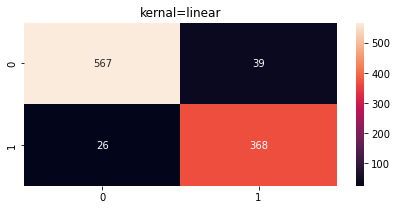

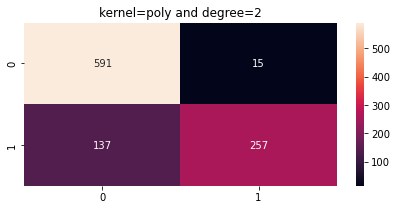

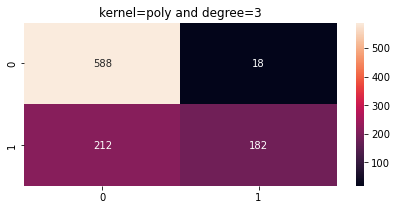

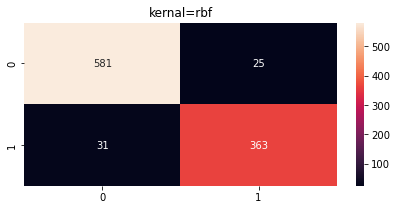

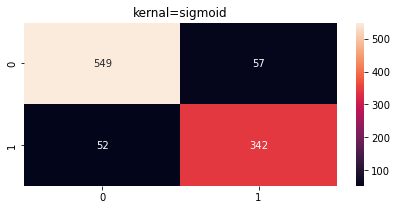

In [35]:
model=SVC(kernel='linear',random_state=123).fit(xtrain,ytrain)
score_matrix(model)

model=SVC(kernel='poly',degree=2,random_state=123).fit(xtrain,ytrain)#二次多项式核
print('degree=2')
score_matrix(model)
plt.title('kernel=poly and degree=2')

model=SVC(kernel='poly',random_state=123,degree=3).fit(xtrain,ytrain)#三次多项式核
print('degree=3')
score_matrix(model)
plt.title('kernel=poly and degree=3')

model=SVC(kernel='rbf',random_state=123).fit(xtrain,ytrain)
score_matrix(model)

model=SVC(kernel='sigmoid',random_state=123).fit(xtrain,ytrain)
score_matrix(model)

分析上述的五种核函数的预测结果可得，径函数Radial Basis Function的预测效果最好。

In [36]:
param_grid={'C':[0.1,1,10],'gamma':[0.01,0.1,1]}
model=GridSearchCV(SVC(kernel='rbf',random_state=123),param_grid=param_grid,cv=kfold).fit(xtrain,ytrain)
print('最优超参数为：',model.best_params_)
model=model.best_estimator_

最优超参数为： {'C': 10, 'gamma': 0.01}


核函数为rbf时
训练集预测准确率为：0.9591780061094141
测试集预测准确率为：0.948
灵敏度为0.9289340101522843
召回率为0.9384615384615385
              precision    recall  f1-score   support

       email       0.95      0.96      0.96       606
        spam       0.94      0.93      0.93       394

    accuracy                           0.95      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000

----------------------------------------------------------------------------------------------------


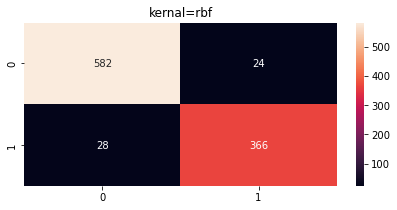

In [37]:
score_matrix(model)

从各项指标均可得出，在使用了最优超参数组合后，模型的预测效果得到了改进。
## 四、支持向量机的多分类问题
支持向量机未推广到多分类问题。对于多分类问题，使用全配对法：对于K类数据，随机抽取两类，可得$C_K^2$个二分类问题，对这$C_K^2$个二分类问题均进行SVM估计，得到$C_K^2$个SVM模型，然后以最常见的预测类别作为最终的预测结果，其实质遵循多数票原则。

In [38]:
data=load_digits()
X=pd.DataFrame(data.data,columns=data.feature_names)
y=data.target

In [39]:
print(data.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [40]:
pd.Series(data.target).value_counts(normalize=True)

3    0.101836
1    0.101280
5    0.101280
4    0.100723
6    0.100723
9    0.100167
7    0.099610
0    0.099054
2    0.098497
8    0.096828
dtype: float64

In [41]:
X.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [42]:
xtrain,xtest,ytrain,ytest=train_test_split(X,np.array(y).ravel(),test_size=0.2,stratify=y,random_state=0)

In [43]:
def metrics(model):

    name=model.get_params()['kernel']

    pred=model.predict(xtest)
    accuracy_train=model.score(xtrain,ytrain)
    accuracy_test=model.score(xtest,ytest)
    f1=classification_report(ytest,pred)
    
    print(f'当核函数为{name}时\n训练集预测准确率为：{accuracy_train}\n测试集预测准确率为：{accuracy_test}')
    print(f1)
    print('-'*100)

In [44]:
model=SVC(kernel='linear',random_state=123).fit(xtrain,ytrain)
metrics(model)

model=SVC(kernel='poly',degree=2,random_state=123).fit(xtrain,ytrain)#二次多项式核
print('degree=2')
metrics(model)

model=SVC(kernel='poly',random_state=123,degree=3).fit(xtrain,ytrain)#三次多项式核
print('degree=3')
metrics(model)

model=SVC(kernel='rbf',random_state=123).fit(xtrain,ytrain)
metrics(model)

model=SVC(kernel='sigmoid',random_state=123).fit(xtrain,ytrain)
metrics(model)

当核函数为linear时
训练集预测准确率为：1.0
测试集预测准确率为：0.9722222222222222
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.88      1.00      0.94        36
           2       1.00      1.00      1.00        35
           3       0.97      0.97      0.97        37
           4       1.00      0.94      0.97        36
           5       0.95      1.00      0.97        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.97      0.86      0.91        35
           9       0.97      0.97      0.97        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360

----------------------------------------------------------------------------------------------------
degree=2
当核函数为poly时
训练集预测准确率为：0.9951287404314544
测试集预测准确率为：0.9888888888888889
      

除了S型核的预测效果不太理想，其他核函数的SVM估计均在测试集取得了相当高的预测准确率，下面使用三次多项核进行交叉验证以选择最优参数组合。

In [45]:
param_grid={'C':[0.001,0.01,0.1,1,10],'gamma':[0.001,0.01,0.1,1,10]}
model=GridSearchCV(SVC(kernel='poly',degree=3,random_state=123),param_grid=param_grid,cv=kfold).fit(xtrain,ytrain)
print('最优参数组合为：',model.best_params_)
model=model.best_estimator_

最优参数组合为： {'C': 0.1, 'gamma': 0.001}


In [46]:
model.get_params()['kernel']

'poly'

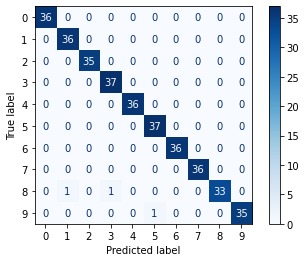

In [47]:
plot_confusion_matrix(model,xtest,ytest,cmap='Blues')

## 五、支持向量回归
SVR的基本思想是，将支持向量机的合页损失函数移植到回归问题，惩罚残差项。，最优化目标函数为：
$$\underset{\beta,\beta_0}\quad \frac{1}{2}\beta^{'}\beta+C\sum_{i=1}^n \xi_{\epsilon}[y_i-f(x_i)]$$
令$z_i=y_i-f(x_i)$，则合页损失函数为：
$$
\xi_{\epsilon}(z_i)=
\begin{cases}
0 & |z_i|\leq\epsilon\\
|z_i|-\epsilon & |z_i|\geq\epsilon\\
\end{cases}$$
由于在一个宽度为2$\epsilon$的间隔带中，损失函数对残差不敏感，故又称”$\epsilon$-不敏感函数“。其类似岭回归，区别是岭回归采用了平方损失函数。


In [48]:
X,y=load_boston(return_X_y=True)
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)
scaler=StandardScaler().fit(xtrain)
xtrain=scaler.transform(xtrain)
xtest=scaler.transform(xtest)

In [49]:
model=SVR(kernel='rbf').fit(xtrain,ytrain)
model.score(xtest,ytest)

0.6638733322326675

In [50]:
kfold

StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [51]:
param_grid={'C':[0.01,0.1,1,10,50,100,150],'epsilon':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
kfold=KFold(n_splits=10,shuffle=True,random_state=1)
model=GridSearchCV(SVR(),param_grid,cv=kfold).fit(xtrain,ytrain)

In [52]:
model.best_params_

{'C': 100, 'epsilon': 1, 'gamma': 0.1}

In [53]:
model.score(xtest,ytest)

0.9155607536119317